- RandomForest, XGBoost는 다중공선성 제거가 필요없지만    
  Lasso는 선형 회귀 기반이라 다중공선성 제거를 해야 함 (L1이라 정규화는 하겠지만)   
- 로그 변환이 필요함 - 타겟 피쳐 + 왜도 > 1 피쳐(데이터 탐색에서 확인)

In [1]:
# 한글, 음수 시각화 설정

#시각화 패키지
import matplotlib.pyplot as plt

#시각화에서 한글을 사용하기 위한 설정
import platform
from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    
#시각화에서 음수를 표현하기 위한 설정
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False 

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd 
import numpy as np
import re 

from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('../../data/prp_factory_glass_2016.csv', index_col= 0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8142 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 197 entries, LIFT.OUT.ROL.MTR.M.SPD to R.Vac
dtypes: float64(197)
memory usage: 12.3+ MB


,LIFT.OUT.ROL.MTR.M.SPD,LEHR.DRV.MTR.M.SPD,DRV.MTR.M.SPD,X,DCS.Offset.RPM.M,DAMP.POSITION.BAY.CTRL,DB.N2.SCREEN.FLOW.LEFT,DB.N2.SCREEN.FLOW.RIGHT,N2.TO.EA1313A,ROOF.HEATING.Zone,...,STD.U.L,STD.U.R,STD.L.L,STD.L.R,STD.GLS.L,STD.GLS.R,L.RD,L.Vac,R.RD,R.Vac
dat...date.name.,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,-1.742443,-1.699444,-1.683797,-0.755452,-1.947792,-1.251006,-1.514135,-1.529208,-0.218748,0.040366,...,0.523950,1.951349,2.248106,2.767676,3.012706,3.069007,0.025,0.063,0.108,0.041
2016-01-01 08,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-1.514135,-1.529208,-0.218748,0.028982,...,0.566521,2.010125,2.364418,2.842630,3.022998,3.069274,0.000,0.022,0.133,0.000
2016-01-01 09,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-1.514135,-1.529208,-0.218748,0.065345,...,0.545936,2.002820,2.397034,2.817728,2.936967,2.969952,0.016,0.063,0.000,0.000
2016-01-01 10,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-1.514135,-1.529208,-0.218748,0.084378,...,0.549254,2.047995,2.399854,2.810619,2.876398,2.914596,0.000,0.103,0.000,0.000
2016-01-01 11,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-1.514135,-1.529208,-0.218748,0.024016,...,0.610913,2.101178,2.379341,2.797094,2.858177,2.873929,0.000,0.000,0.000,0.000


> ### 왼쪽 공정만 추출

- 왼쪽 공정 중 L / l이 포함된 경우 lower과 겹칠 가능성이 있어 제외 안함

In [4]:
cols = df.columns

# 1. LEFT 키워드 , RIGHT 키워드
left_keyword_cols = [
    col for col in cols
    if re.search(r'(LEFT|U\.L|L\.L|u\.l|l\.l|L\.RD|L\.Vac)', col, flags=re.IGNORECASE)
]

right_keyword_cols = [
    col for col in cols
    if re.search(r'(RIGHT|U\.R|L\.R|u\.r|l\.r|R\.RD|R\.Vac|\.R\b)', col, flags=re.IGNORECASE)
]

# 2. 공통 공정 = LEFT도 아니고 RIGHT도 아닌 컬럼
common_cols = [col for col in cols if col not in left_keyword_cols and col not in right_keyword_cols]

# 데이터프레임 구성
left_feature_df = df[left_keyword_cols].copy()
right_feature_df = df[right_keyword_cols].copy()
common_feature_df = df[common_cols].copy()

# 결과 확인
print("✅ 왼쪽 공정 수:", len(left_feature_df.columns))
print("✅ 오른쪽 공정 수:", len(right_feature_df.columns))
print("✅ 공통 공정 수:", len(common_feature_df.columns))


✅ 왼쪽 공정 수: 30
✅ 오른쪽 공정 수: 42
✅ 공통 공정 수: 126


In [5]:
# 왼쪽 feature_df 구성
left_df = pd.concat([common_feature_df, left_feature_df], axis=1)
print("✅ 최종 왼쪽 feature_df 컬럼 수:", left_df.shape[1])


✅ 최종 왼쪽 feature_df 컬럼 수: 156


> ### 피쳐 - 타겟 분리

In [6]:
left_df.head()

,LIFT.OUT.ROL.MTR.M.SPD,LEHR.DRV.MTR.M.SPD,DRV.MTR.M.SPD,X,DCS.Offset.RPM.M,DAMP.POSITION.BAY.CTRL,N2.TO.EA1313A,ROOF.HEATING.Zone,ATM.FLOW.SECT.N2.H2,ATM.FLOW.SECT.N2,...,S.AB.AB.U.L,S.AB.AB.L.L,S.AB.C.U.L,S.AB.C.L.L,S.C.C.U.L,S.C.C.L.L,STD.U.L,STD.L.L,L.RD,L.Vac
dat...date.name.,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,-1.742443,-1.699444,-1.683797,-0.755452,-1.947792,-1.251006,-0.218748,0.040366,-1.812108,0.172787,...,0.047915,-0.172226,0.146778,1.772574,1.405119,0.785430,0.523950,2.248106,0.025,0.063
2016-01-01 08,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-0.218748,0.028982,-1.792364,0.252142,...,0.025103,-0.189845,0.161917,1.871182,1.433834,0.749426,0.566521,2.364418,0.000,0.022
2016-01-01 09,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-0.218748,0.065345,-1.815574,0.283121,...,0.009143,-0.196662,0.153177,1.826206,1.446866,0.805319,0.545936,2.397034,0.016,0.063
2016-01-01 10,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-0.218748,0.084378,-1.846923,0.157744,...,-0.018994,-0.201060,0.173210,1.853880,1.434837,0.751488,0.549254,2.399854,0.000,0.103
2016-01-01 11,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-0.218748,0.024016,-1.855973,0.180923,...,-0.037802,-0.204591,0.163199,1.792980,1.447733,0.816928,0.610913,2.379341,0.000,0.000


In [7]:
feature_df = left_df.iloc[:, :-2]
feature_df.head()

target_df = left_df[['L.RD']] # 다른 변수들의 선형 결합이므로
target_df.head()

,L.RD
dat...date.name.,
2016-01-01 07,0.025
2016-01-01 08,0.000
2016-01-01 09,0.016
2016-01-01 10,0.000
2016-01-01 11,0.000


In [8]:
# 1. NaN이 포함된 열만 추출
nan_cols = feature_df.columns[feature_df.isnull().any()]

# 2. 각 열별 NaN 개수 출력
nan_summary = feature_df[nan_cols].isnull().sum()

print("🔍 로그 변환 전 결측치 열:")
print(nan_summary.sort_values(ascending=False))

🔍 로그 변환 전 결측치 열:
Series([], dtype: float64)


> ### 로그 변환

- 피쳐 데이터 중 왜도 > 1
- 타겟 데이터

In [9]:
skewed_feats = feature_df.apply(skew)
skewed_cols = skewed_feats[abs(skewed_feats) > 1.0].index

In [10]:
feature_log_df = feature_df.copy()

In [11]:
# 사인 함수 + 로그 변환
def signed_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))

# 적용
feature_df[skewed_cols] = feature_df[skewed_cols].apply(signed_log_transform)
target_df = target_df.apply(np.log1p)

In [12]:
# 변환 후 NaN 발생한 컬럼 확인
nan_cols = feature_log_df.columns[feature_log_df.isnull().any()]
print("🚨 변환 후 NaN 발생한 열:")
print(nan_cols)
print(len(nan_cols))

🚨 변환 후 NaN 발생한 열:
Index([], dtype='object')
0


In [13]:
target_df.head()

,L.RD
dat...date.name.,
2016-01-01 07,0.024693
2016-01-01 08,0.000000
2016-01-01 09,0.015873
2016-01-01 10,0.000000
2016-01-01 11,0.000000


> ### train-test 분리

In [14]:
X_train, X_test, y_train , y_test = train_test_split(feature_df, target_df, test_size=0.2, random_state= 42, )

print('X_train : ', X_train.shape)
print('X_test : ', X_test.shape)
print('y_train : ', y_train.shape)
print('y_test : ', y_test.shape)

X_train :  (6513, 154)
X_test :  (1629, 154)
y_train :  (6513, 1)
y_test :  (1629, 1)


> ### Lasso Model 적용

In [15]:
lasso_model = make_pipeline(
    StandardScaler(),
    LassoCV(cv=5, random_state=42, max_iter=10000)
)

lasso_model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv', LassoCV(cv=5, max_iter=10000, random_state=42))])

In [16]:
lasso_model.score(X_train, y_train) # 38% > 41.3(공정명 숫자 제거 후 mean했더니)
lasso_model.score(X_test, y_test) # 33.5% > 37.01(공정명 숫자 제거 후 mean했더니)

0.37013952547819906

In [17]:
y_pred = lasso_model.predict(X_test)

print("✅ RMSE:", mean_squared_error(y_test, y_pred, squared=False)) # 예측값 - 실제값 사이 평균 오차 
print("✅ R² score:", r2_score(y_test, y_pred)) # 전체 변동성 중 설명 가능한 변동성

# 중요 피처 추출
coef = lasso_model.named_steps['lassocv'].coef_
selected_features = pd.Series(coef, index=X_train.columns)
selected_features = selected_features[selected_features != 0].sort_values(key=abs, ascending=False)

print("🎯 선택된 주요 공정 피처 15개:")
print(selected_features.head(15))

✅ RMSE: 0.0301520510587012
✅ R² score: 0.37013952547819906
🎯 선택된 주요 공정 피처 15개:
STD.GLS.L                -0.075522
l.n.glass                 0.053522
TMP.GLASS.ZONE.AB.L2     -0.043268
S.AB.C.L                  0.042263
cluster                   0.037223
TMP.GLASS.ZONE.AB.L4      0.034107
TMP.GLASS.LEFT.EXIT       0.030668
l.top.n.mean             -0.027310
N2.TO.EA1313A.PV          0.027076
DAMP.POSITION.BAY.CTRL    0.024225
ATM.FLOW.SECT.N2.H2       0.021956
UPPER.C.Z.TMP            -0.021875
TMP.GLASS.ZONE.C.E5       0.021858
STD.L.L                   0.021495
S.AB.AB.L                -0.020613
dtype: float64


> ### 주요 공정 분포 확인

In [18]:
main_features = selected_features.keys()[:15]
print(main_features)

Index(['STD.GLS.L', 'l.n.glass', 'TMP.GLASS.ZONE.AB.L2', 'S.AB.C.L', 'cluster',
       'TMP.GLASS.ZONE.AB.L4', 'TMP.GLASS.LEFT.EXIT', 'l.top.n.mean',
       'N2.TO.EA1313A.PV', 'DAMP.POSITION.BAY.CTRL', 'ATM.FLOW.SECT.N2.H2',
       'UPPER.C.Z.TMP', 'TMP.GLASS.ZONE.C.E5', 'STD.L.L', 'S.AB.AB.L'],
      dtype='object')


In [19]:
feature_df[main_features].describe()

,STD.GLS.L,l.n.glass,TMP.GLASS.ZONE.AB.L2,S.AB.C.L,cluster,TMP.GLASS.ZONE.AB.L4,TMP.GLASS.LEFT.EXIT,l.top.n.mean,N2.TO.EA1313A.PV,DAMP.POSITION.BAY.CTRL,ATM.FLOW.SECT.N2.H2,UPPER.C.Z.TMP,TMP.GLASS.ZONE.C.E5,STD.L.L,S.AB.AB.L
count,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000
mean,-0.001285,-0.103507,-0.014070,0.000462,-0.001868,-0.014111,0.101984,-0.091695,-0.107954,0.000313,0.063487,-0.000146,-0.000346,0.001536,-0.000204
std,0.996792,0.405634,0.461900,1.000413,0.998962,0.465594,0.392758,0.532816,0.476505,0.983183,0.557958,0.830505,1.000439,0.993927,0.455548
min,-4.945022,-0.558408,-2.084387,-4.585751,-1.747928,-2.037943,-1.765912,-0.828159,-1.214259,-1.257404,-1.079350,-2.455428,-3.465857,-3.494243,-3.132077
25%,-0.689852,-0.229976,-0.354084,-0.717893,-0.840522,-0.356200,0.131412,-0.392706,-0.238620,-1.218385,-0.046275,-0.640535,-0.493344,-0.521130,-0.180436
50%,-0.130917,-0.206271,-0.012662,-0.175079,-0.026184,-0.012781,0.155553,-0.286998,-0.231596,-0.009039,0.324203,0.117578,0.221225,0.188246,0.026090
75%,0.439845,-0.188531,0.299432,0.454688,0.857955,0.294926,0.203403,-0.006702,-0.222130,0.896859,0.462679,0.636178,0.739610,0.693591,0.231149
max,5.830432,1.788174,2.999042,6.917178,1.788628,2.970137,0.788716,1.643996,1.874000,1.431630,0.661679,4.685755,2.544437,4.609240,3.107288


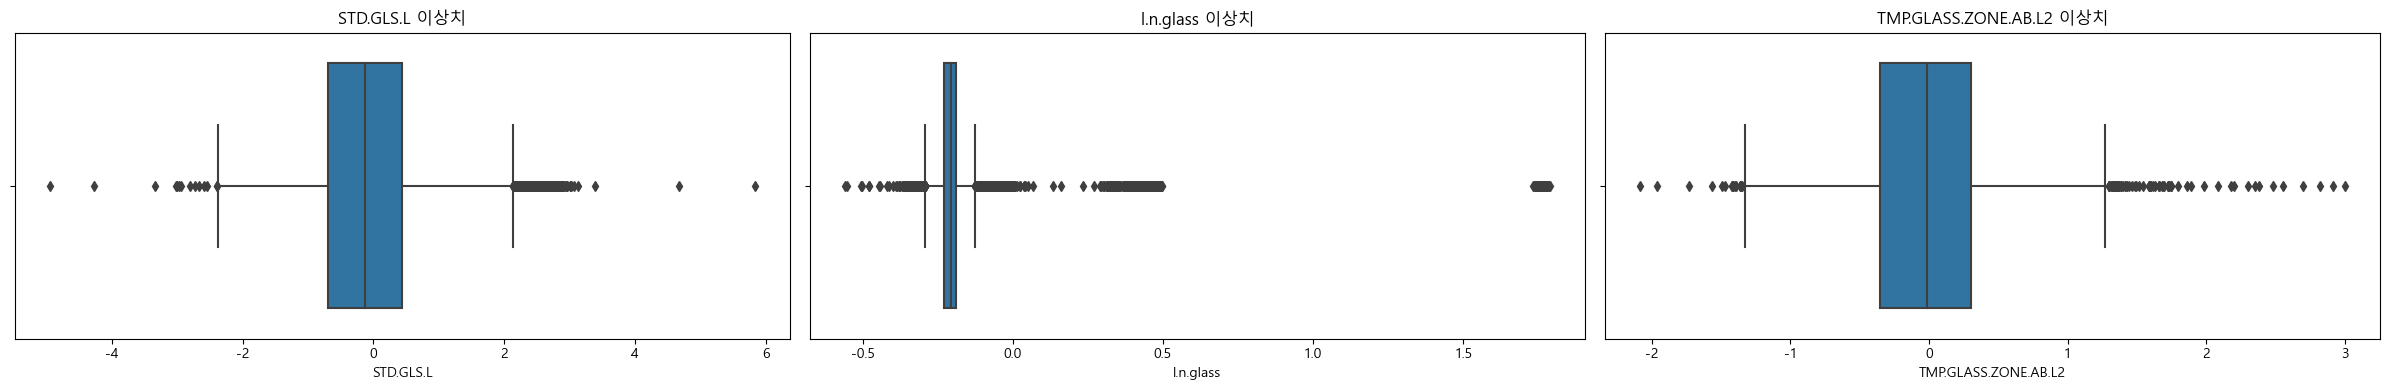

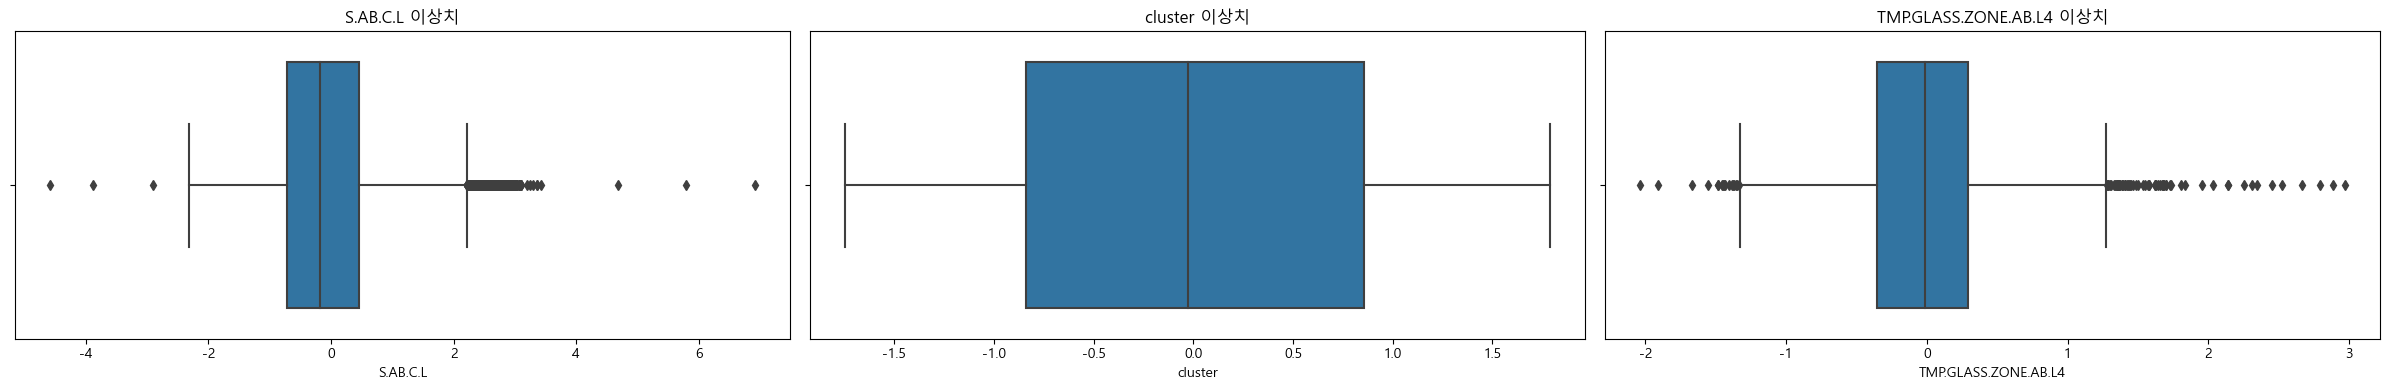

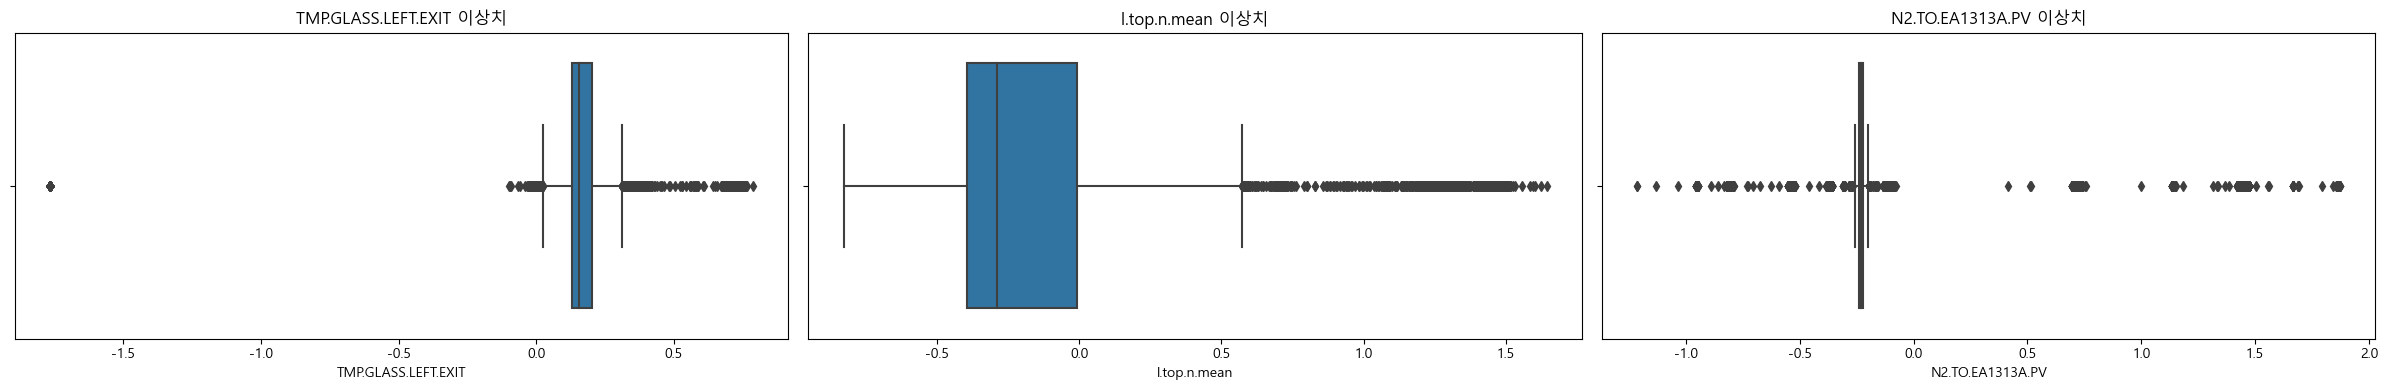

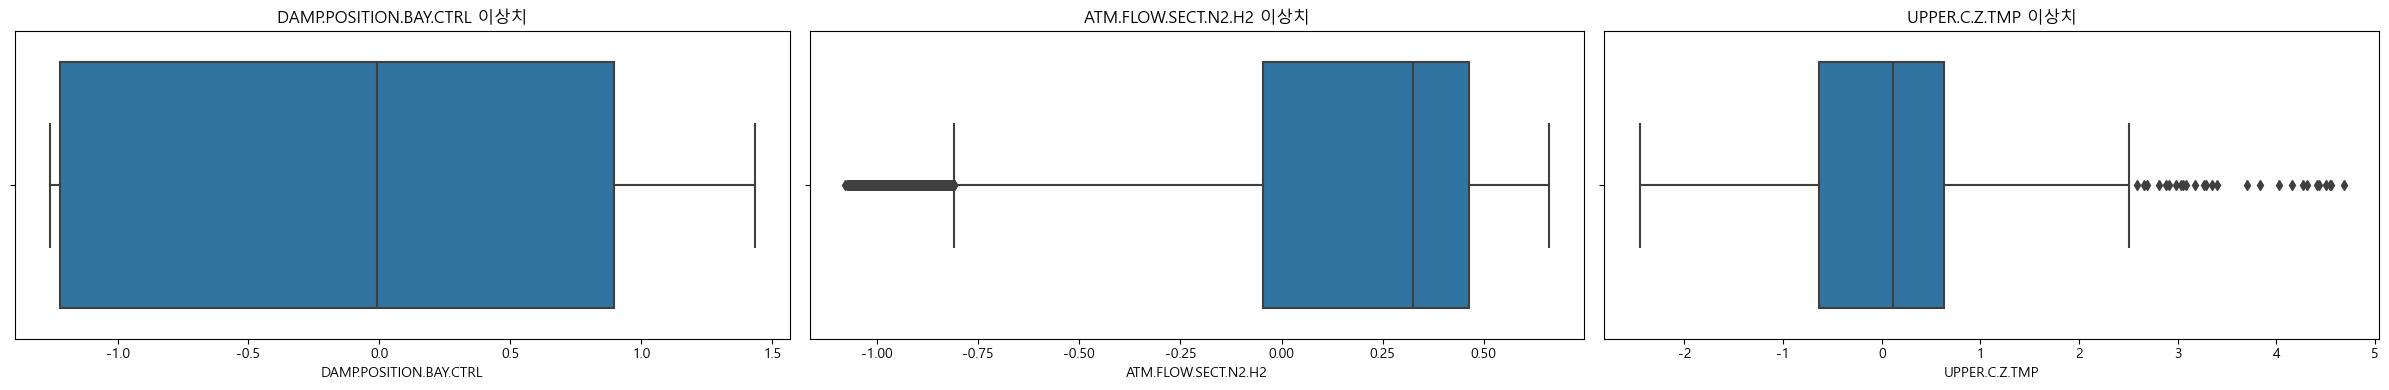

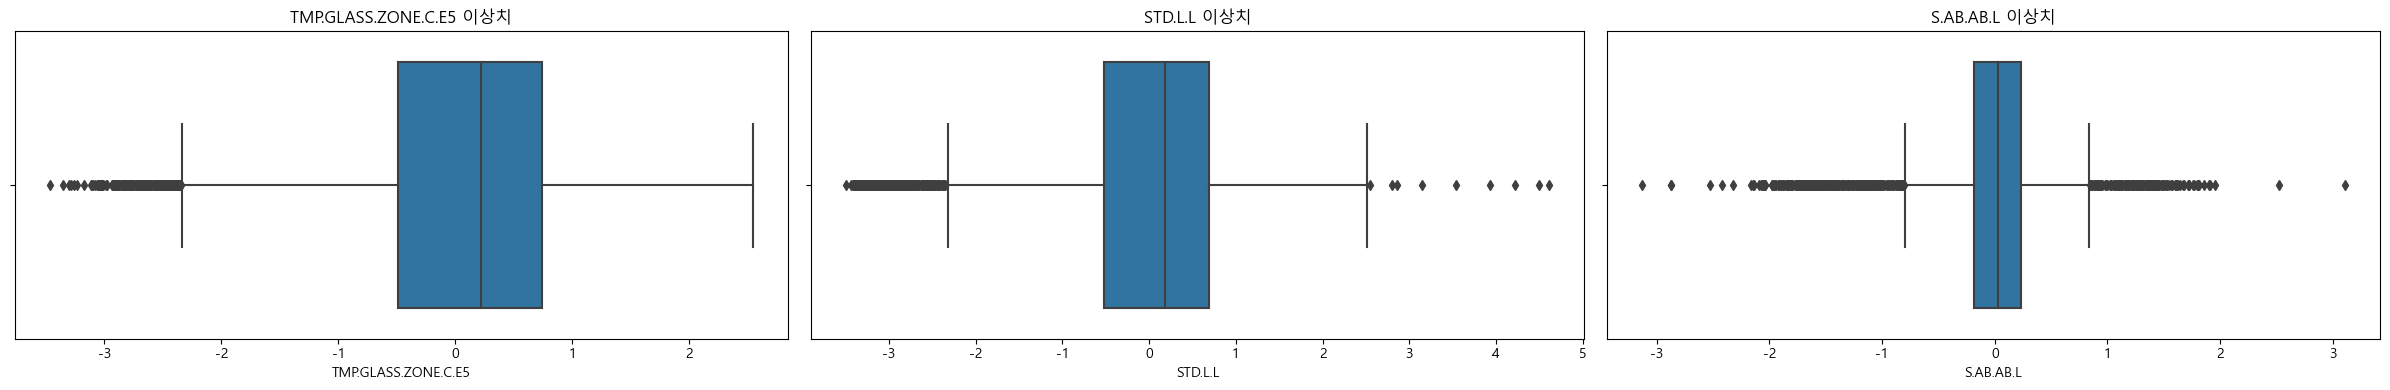

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

n_cols = 3  # 한 행에 3개씩
n_rows = math.ceil(len(main_features) / n_cols)

for i in range(0, len(main_features), n_cols):
    features_chunk = main_features[i:i + n_cols]
    fig, axes = plt.subplots(1, len(features_chunk), figsize=(8 * len(features_chunk), 4))

    if len(features_chunk) == 1:
        axes = [axes]  # 한 개일 경우도 리스트로 변환

    for ax, col in zip(axes, features_chunk):
        sns.boxplot(data=feature_df, x=col, ax=ax)
        ax.set_title(f"{col} 이상치")

    plt.tight_layout()
    plt.show()

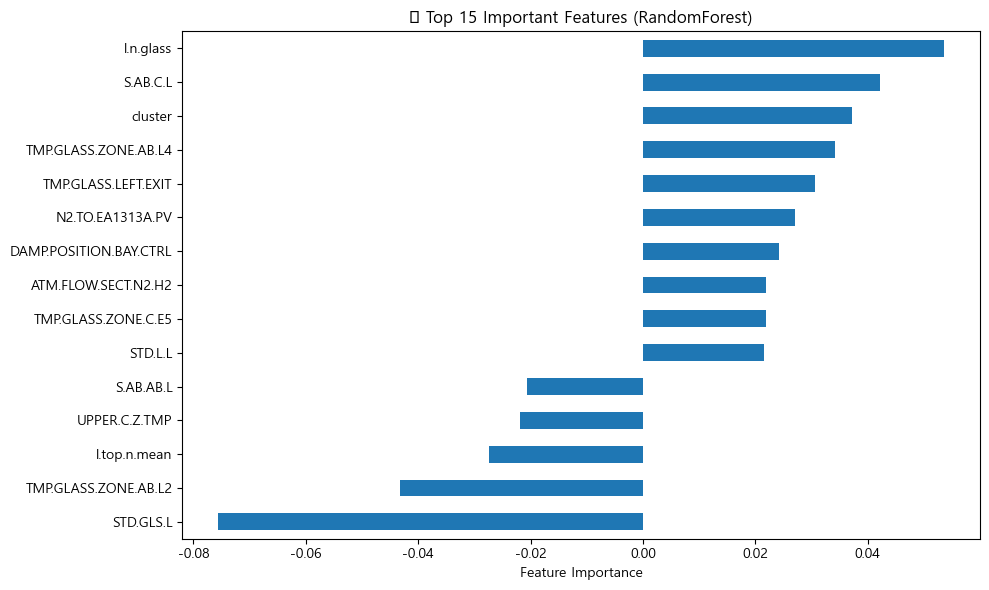

In [21]:
# 시각화: 상위 15개 피처 중요도
plt.figure(figsize=(10, 6))
selected_features.head(15).sort_values().plot(kind='barh')
plt.xlabel("Feature Importance")
plt.title("🎯 Top 15 Important Features (RandomForest)")
plt.tight_layout()
plt.show()